# Income Prediction from Census Data

## Summary
This report presents a comprehensive analysis of the [Census Income dataset](https://archive.ics.uci.edu/dataset/2/adult), predicting whether individuals earn above or below $50,000 annually (1994 pricing). The analysis encompasses data cleaning, exploratory analysis, feature engineering, model development, and evaluation, culminating in a comparison of Generalized Linear Model (GLM) and Gradient Boosting Machine (GBM) approaches.

### Key Results:
- Final Model: LightGBM achieved 87.4% cross-validated accuracy on test set with excellent probability calibration (Gini coefficient 0.654, AUC ≈ 0.827)

- Top Predictive Features:
    - Age (554 splits) - Life-cycle earnings pattern
    - Capital Net (527 splits) - Investment income indicator
    - Hours per Week (309 splits) - Full-time vs part-time distinction
    - Education (268 splits) - Human capital investment
    - Relationship Married (66 splits) - Household income dynamics

- Model Performance:
    - 18-19% error reduction vs GLM baseline (MAE: 0.174 vs 0.216)
    - Excellent calibration: Only 1.6% bias (predictions match actual rates)
    - Strong ranking ability: Gini 0.654 enables effective targeting of top prospects
    - Outperforms GLM across all 8 evaluation metrics with substantial margins


## Motivation for the Prediction Task

Accuratley predicting individual income levels has significant practical applications across multiple sectors:

**Government & Public Policy:**
- **Welfare Eligibility Screening:** In countries lacking centralized income tracking (e.g., UK), predictive models can help identify individuals likely eligible for means-tested benefits (Winter Fuel Payment, Universal Credit) without intrusive income verification.
- **Targeted Outreach:** Enables efficient allocation of resources by identifying populations most likely to need assistance programs.

**Non-Profit Sector:**
- **Donor Prospecting:** Charities often use crude proxies (e.g., age, postcode) for wealth assessment during door-to-door fundraising. Data-driven income prediction can improve targeting efficiency, reducing wasted outreach while respecting privacy.
- **Campaign Optimization:** Identify high-value donor prospects for major gift campaigns vs. mass-market appeals.

**Financial Services:**
- **Customer Acquisition:** Banks, accountants, and financial advisers see higher demand from affluent clients. Income prediction enables cost-effective targeting of premium services through digital advertising platforms (Facebook, LinkedIn) that offer rich demographic targeting.
- **Product Recommendation:** Tailor financial product offerings (premium credit cards, investment services) based on predicted income segment.
- **Credit Risk Assessment:** Income prediction serves as an input to credit scoring models when direct income verification is unavailable.

**Privacy Consideration:** This approach offers an alternative to directly collecting sensitive income data, using publicly available demographic features to make probabilistic inferences—balancing business needs with individual privacy.

**This Analysis:** Using 1994 US Census data, we develop and evaluate income prediction models to demonstrate the feasibility and accuracy of this approach, with insights transferable to modern applications.

## Explanatory data analysis

### Dataset Overview
The Census Income dataset from the UCI Machine Learning Repository contains demographic and employment information extracted from the 1994 US Census. The prediction task is to determine whether an individual's income exceeds $50,000 per year; adjusting for inflation, this income is equivelent to $110,000 in 2025.

**Dataset Characteristics**:
- Samples: 48,842 individuals
- Original Features: 15 variables
- Target Variable: Binary income classification (<=50K, >50K)
- Source: US Census Bureau, 1994

**Coulmn Description**

| Column | Type | Description | Values/Range | Cleaned Version |
|---------|------|-------------|--------------|-----------------|
| age | Numeric | Age in years | 17-90 | No change |
| workclass | Categorical | Employment sector | Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked | rename to work_class |
| fnlwgt | Numeric | Final sampling weight | - | **Dropped** |
| education | Categorical | Highest education level | Preschool, 1st-4th, 5th-6th, 7th-8th, 9th, 10th, 11th, 12th, HS-grad, Some-college, Assoc-voc, Assoc-acdm, Bachelors, Masters, Prof-school, Doctorate | Manually ordered values and converted to integer. 1 = lowest level of education, 16 = highest level |
| education-num | Numeric | Education in years | - | **Dropped** |
| marital-status | Categorical | Marital status | - | **Dropped** |
| occupation | Categorical | Job type | Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces | rename to occupation |
| relationship | Categorical | Family relationship | Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried | rename to  relationship, transformed Husband/Wife values to Married |
| race | Categorical | Race | White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black | rename to race |
| sex | Categorical | Sex | Male, Female | renamed to sex |
| capital-gain | Numeric | Capital gains | 0-99999 | **Combined** into capital_net |
| capital-loss | Numeric | Capital losses | 0-4356 | **Combined** into capital_net |
| hours-per-week | Numeric | Hours worked per week | 1-99 | rename to hours_per_week |
| native-country | Categorical | Country of birth | United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands | rename to  native_country |
| income | Categorical | Annual income | <=50K, >50K | Fixed bad labels. Converted to boolean and rename to **high_income** |


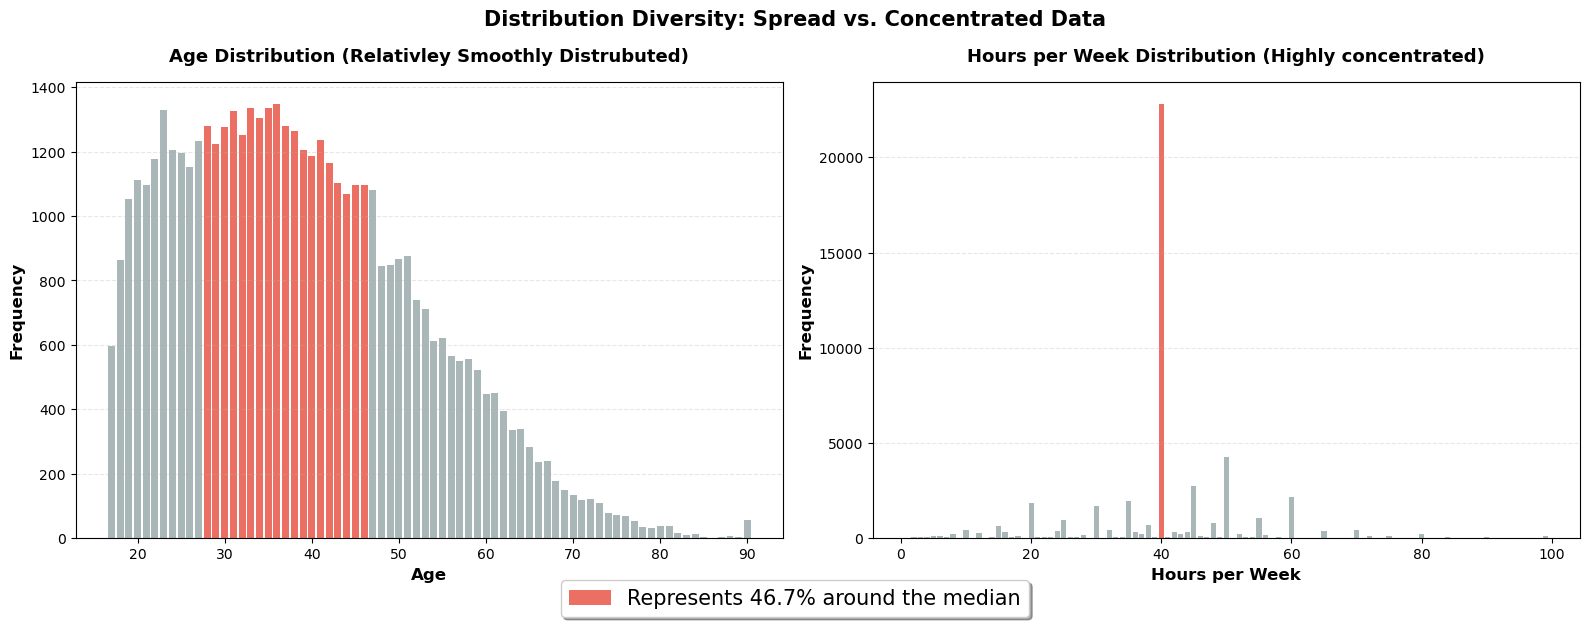

In [5]:
import pandas as pd
from pathlib import Path
import sys

current_dir = Path.cwd()
src_directory = current_dir.parent
sys.path.append(str(src_directory))

from notebooks.visualisations import display_dataset, distribution_variety

parquet_path = src_directory / "data" / "census_income.parquet"

df_raw = pd.read_parquet(parquet_path)

distribution_variety.distribution_variety(df_raw)

**Distribution Insights**:

Not all numerical columns distribute similarly. While age shows a relatively smooth spread, hours-per-week is highly concentrated with a single value (40 hours) representing 46.7% of the dataset. This concentration makes sense, as 40 hours is the standard full-time employment, whereas age varies naturally across the population. Understanding these distribution patterns is essential for appropriate statistical analysis and modeling decisions.

### Initial Data Quality Assessment

There were a number of minor data quality issues with the dataset, many of which could be resolved by simple transformations of the dataset. Below visualise some of the data quality problems that needed to be dealt with. 

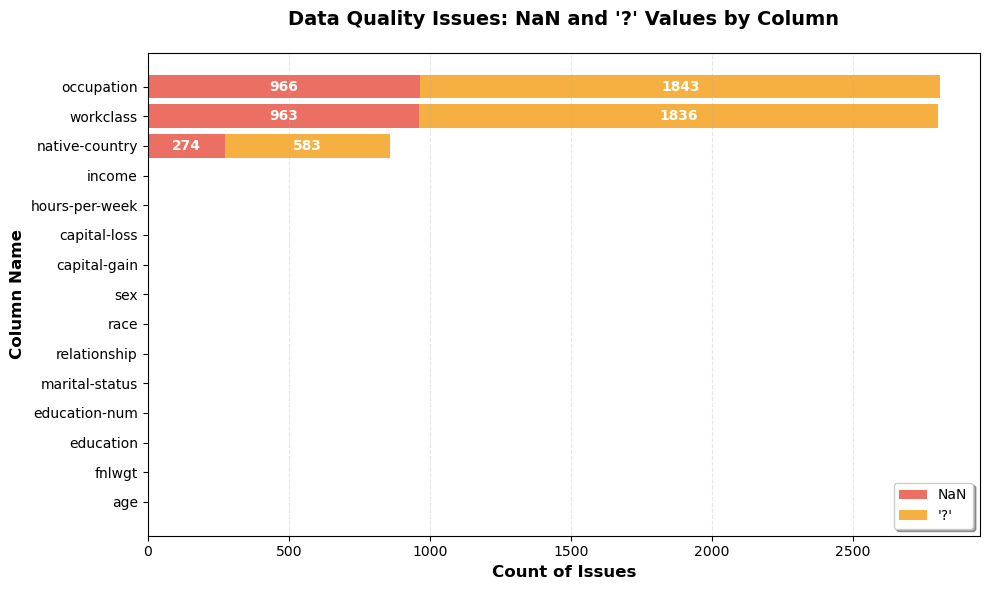

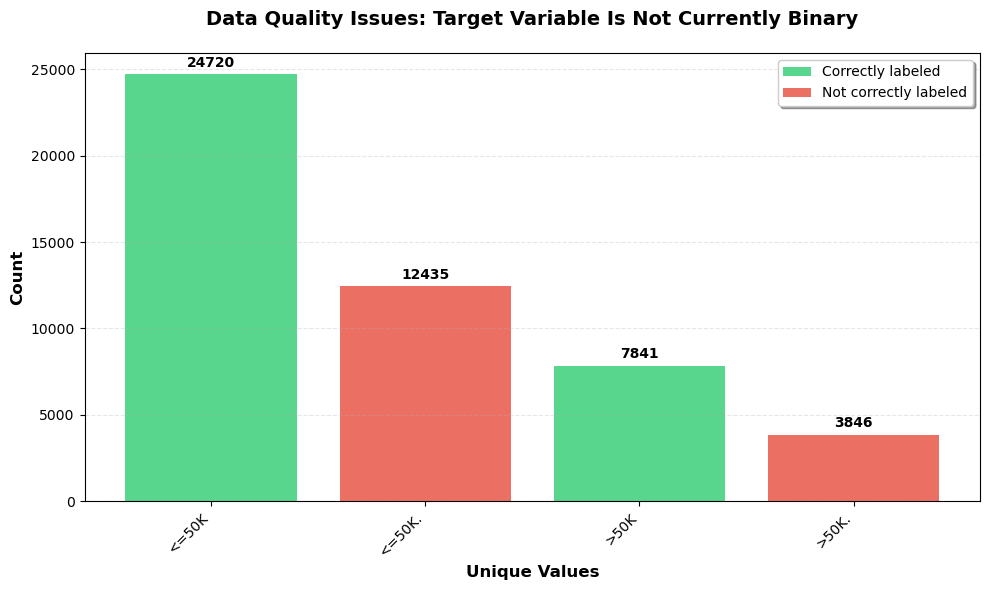

In [2]:
from notebooks.visualisations import visualize_missing_data, binary_column_issue

visualize_missing_data.visualize_missing_data(df_raw)
binary_column_issue.binary_column_issue(df_raw, 'income', expected_values=['<=50K', '>50K'])

Below list all cleaning steps taken:
- Add unique ID column (there were 29 duplicates, this isn't unexpected as some people will have the same demographics. Adding unique ID allows us to tell these individuals appart)
- Clean column names (e.g. 'capital-gain' -> 'capital_gain')
- Remove seemingly redundant columns ('fnlwgt', 'education-num')
- clean income data (there were some values with a '.' at the beginning e.g. '>50K.') 
- binarize income data (1 for '>50K', 0 for '=<50K') and rename to 'high_income'
- Replace '?' values with pandas NaN
- trim whitespace from all str values
- Order and transform 'education' column. Change datatype from str into int (e.g. 'Preschool' = 1 < '1st-4th' = 2 < ... < 'Doctorate' = 16)
- Transform capital-gain and capital-loss into a single column capital-net
- Relationship field was slightly simplified, bundling 'Wife' and 'Husband' into one value, 'Married'

All cleaning steps were split modularly into their own functions in the file cleaning.py. Can be run together using the full_clean function in cleaning.py.

In [3]:
from income_predict import cleaning

df_clean = cleaning.full_clean(df_raw)

## Feature Selection & Engineering Selection

### Feature Selection Rationale

#### Numeric Features - Why Included:
- **age**: Strong correlation with income (see visualisation below)
- **education**: Ordinal encoding preserves natural ordering; highest correlation with income
- **capital_net**: Combined feature captures investment income; strong predictor for high earners
- **hours_per_week**: Work hours correlate with income; distinguishes full-time vs part-time

#### Categorical Features - Why Included:
- **work_class**: Employment sector (private/government/self-employed) affects income
- **occupation**: Job type strongly associated with income levels (see visualisation below)
- **relationship**: Household role correlated with income (married couples often dual income)
- **race**: Demographic factor that may reflect systemic patterns
- **sex**: Gender wage gap documented in literature
- **native_country**: Immigration status and country of origin may affect opportunities

#### Features Excluded and Why:
- **fnlwgt**: Sampling weight for census data, not predictive of individual income
- **education-num**: Redundant with categorical education (now ordinal education)
- **marital_status**: Excluded to avoid multicollinearity with relationship
- **capital_gain / capital_loss**: Combined into capital_net to reduce dimensionality
- **unique_id**: There should be no correlation with the way the IDs were generated and people's income (see visualisation below)

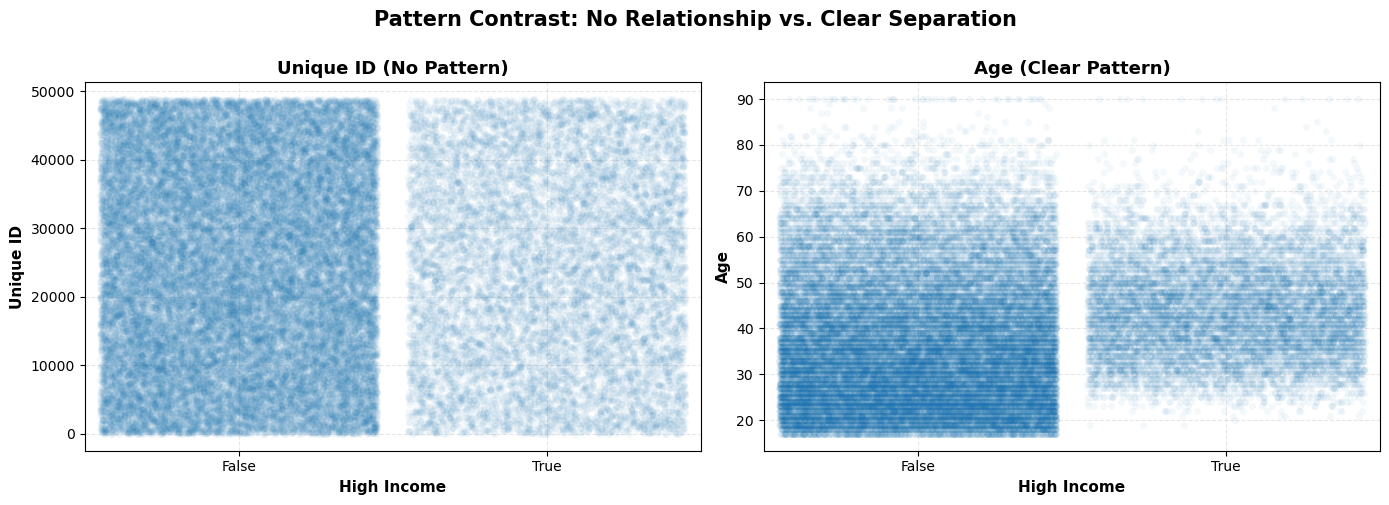

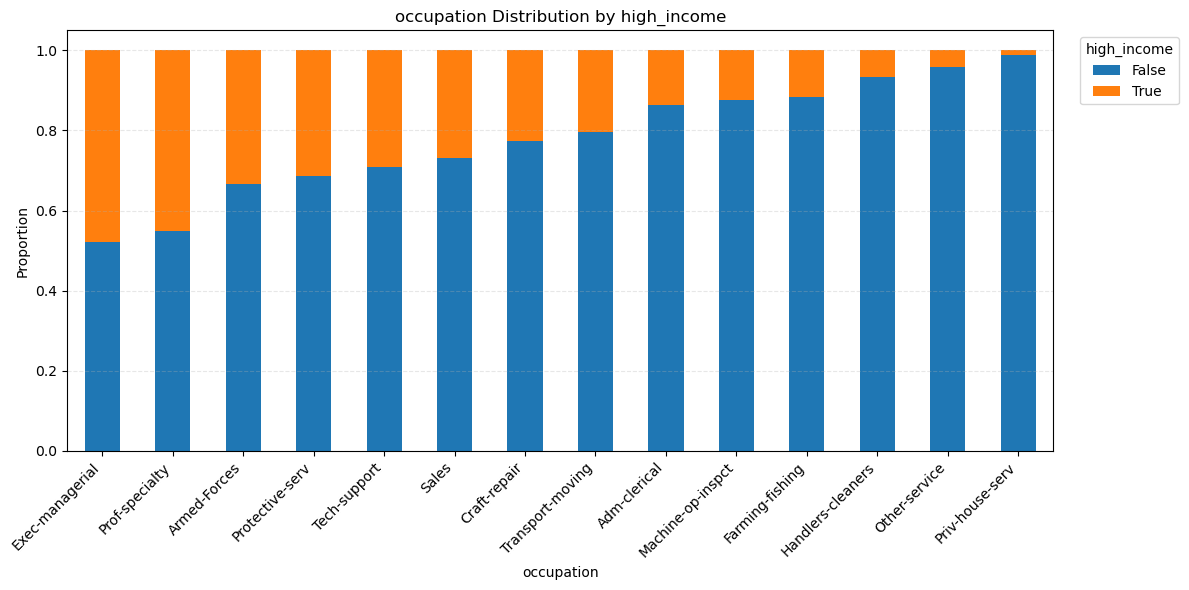

In [4]:
from notebooks.visualisations import correlation_compare, occupation_correlation

correlation_compare.correlation_compare(df_clean)
occupation_correlation.occupation_correlation(df_clean)


### Feature Engineering Approach

#### 1. Education Ordinal Encoding
```
EDUCATION_ORDER = {
    "Preschool": 1, "1st-4th": 2, "5th-6th": 3, "7th-8th": 4,
    "9th": 5, "10th": 6, "11th": 7, "12th": 8,
    "HS-grad": 9, "Some-college": 10,
    "Assoc-voc": 11, "Assoc-acdm": 12,
    "Bachelors": 13, "Masters": 14,
    "Prof-school": 15, "Doctorate": 16
}
```

**Motivation**:

- Education has natural ordering (more education generally leads to higher income)
- Ordinal encoding (1-16) preserves this relationship
- Allows models to capture monotonic trends more easily than one-hot encoding
- Reduces dimensionality compared to 16 binary features

#### 2. Capital Net Feature
```
df['capital_net'] = df['capital_gain'] - df['capital_loss']
```

**Motivation**:

- Most people have zero capital gains AND losses (sparse features)
- Net capital is what matters for income classification
- Reduces two features to one without information loss
- Simplifies model by removing highly correlated features

#### 3. Relationship Simplification
```
df['relationship'] = df['relationship'].replace({'Husband': 'Married', 'Wife': 'Married'})
```

**Motivation**:

- 'Husband' and 'Wife' represent same relationship type (married)
- Gender already captured in separate sex feature
- Reduces categories from 6 to 5, simplifying model
- Maintains meaningful distinction (married vs single vs other family roles)

### Train-Test Split Strategy

**Split Methodology**:
- Method: Hash-based splitting on unique_id
- Ratio: 80% train, 20% test
- Reproducibility: Hash function ensures same split across runs

**Rationale**:
- Hash-based splitting avoids random seed dependence
- Same individual always in same set (no data leakage)
- 80/20 provides sufficient training data while maintaining robust test set

## Modelling

### Model Selection

Two complementary approaches were selected:

1. Generalized Linear Model (GLM) - Logistic Regression
2. LightGBM (Gradient Boosting Machine)

**Why GLM?**:

- Interpretability: Coefficients show linear relationship between each feature and the target
- Baseline: Establishes performance floor. Simpler models preferred if comparable
- Probabilistic: Natural probability outputs for binary classification
- Fast Training: Scales well to large datasets
- Assumptions: Appropriate if relationships are approximately linear

**Why LGBM?**:

- Non-linear Relationships: Captures complex interactions between features
- Feature Interactions: Automatically learns combinations without manual engineering
- Robust: Handles missing values, outliers, and mixed feature types well
- Performance: Generally highly accurate, in comparisson to GLM and other boosting models
- Feature Importance: Provides interpretable feature rankings

### Evaluation Approach

#### Metric Selection

Metric Selection and Rationale:

| Metric | Why Important | Interpretation |
|--------|---------------|----------------|
| **Accuracy** | Overall correctness | % of correct predictions |
| **Precision** | Minimize false positives | Of predicted high-income, % actually high-income |
| **Recall** | Minimize false negatives | Of actual high-income, % correctly identified |
| **F1-Score** | Balance precision/recall | Harmonic mean; useful for imbalanced data |
| **ROC-AUC** | Ranking quality | Probability of ranking random positive > negative |
| **Log Loss** | Probability calibration | Penalizes confident wrong predictions |


**Primary Metric/s**: It depends on the exact business question. For example, charity donor prospecting will likley want a model with high **Precision** and **Log Loss**, so that they can target people that are most likley to have high income. Another example would be for government public policy that is keen to understand where both high income and not high income people are, **Accuracy** would be the most valuable metric to them.

#### Evaluation Strategy

- Train Set: Used for model training and hyperparameter tuning (with cross-validation)
- Test Set: Held out for final evaluation only (no model selection on test set)
- Cross-Validation: 5-fold stratified CV during hyperparameter tuning
    - Ensures robust parameter selection
    - Reduces overfitting to single validation split
    - Maintains class balance in each fold
- Preventing Overfitting:
    - Separate train/test split (no test set leakage)
    - Cross-validation for hyperparameter selection
    - Regularization in GLM (L1/L2 penalty)
    - Early stopping consideration in LGBM

### Hyperparameter Tuning

#### GLM Tuning

**Parameters selected**:
| Parameter | Search Space | Purpose | Baseline Value | Tuned Value |
|-----------|--------------|---------|----------------|----------------|
| `alpha` | 10^-4 to 10^-1 (log-uniform) | Regularization strength (higher = more regularization) | 0.0001 | **0.000598** |
| `l1_ratio` | 0 to 1 (uniform) | Balance between L1 (Lasso) and L2 (Ridge) penalty | 0.15 | **0.663** |

**Performance Improvement:**
- **Baseline Accuracy:** 84.0%
- **Tuned Accuracy:** 84.6%
- **Improvement:** +0.6 percentage points

**Selected Parameters Interpretation:**
- **Alpha = 0.000598:** 6x increase from baseline
  - Still relatively low, suggesting model not significantly overfitting
  - Slight increase provides better generalization without excessive constraint
  
- **L1 Ratio = 0.663:** Elastic Net with stronger L1 (Lasso) component
  - Strong shift from baseline (0.15 to 0.663) indicates benefit of L1 regularization
  - Promotes sparsity: some features get zeroed coefficients (automatic feature selection)
  - L1 component (66.3%) encourages simpler model by eliminating weak predictors
  - L2 component (33.7%) still helps with correlated features (e.g., one-hot encoded categories)

**Why This Configuration Works:**
- Higher L1 ratio eliminates less important one-hot encoded categories
- Moderate alpha prevents overfitting while retaining strong predictors
- Elastic Net (mix of L1/L2) balances feature selection with stability

**Tuning Process:**
- **Method:** Randomized search (more efficient than grid search for continuous parameters)
- **Iterations:** 50 random combinations sampled
- **Cross-Validation:** 5-fold stratified ensures robust evaluation
- **Search Strategy:** Log-uniform for `alpha` (covers multiple orders of magnitude)

#### LGBM Tuning

**Parameters selected**:
| Parameter | Search Space | Purpose | Baseline Value | Tuned Value |
|-----------|--------------|---------|----------------|----------------|
| `learning_rate` | 0.01 to 0.2 (log-uniform) | Controls step size in gradient descent | 0.1 | **0.158** |
| `n_estimators` | 50 to 200 (integer) | Number of boosting rounds (trees) | 100 | **89** |
| `num_leaves` | 10 to 60 (integer) | Maximum leaves per tree (complexity) | 31 | **30** |
| `min_child_weight` | 0.0001 to 0.002 (log-uniform) | Minimum sum of instance weight in leaf (regularization) | 0.001 | **0.00013** |

**Performance Comparison:**
- **Baseline Accuracy:** 87.5%
- **Tuned Accuracy:** 87.4%
- **Change:** -0.1 percentage points (negligible decrease)

**Selected Parameters Interpretation:**
- **Learning Rate = 0.158:** Higher than baseline (0.1 to 0.158)
  - 58% increase in step size suggests faster convergence preferred
  - Higher learning rate often pairs with fewer trees to prevent overfitting
  - Allows model to learn more aggressively per iteration
  
- **N_estimators = 89:** Fewer trees than baseline (100 → 89)
  - Reduction of 11 trees compensates for higher learning rate
  - Trade-off: higher LR × fewer trees ≈ similar total learning
  - Slightly more efficient (fewer trees = faster inference)
  
- **Num_leaves = 30:** Slightly simpler trees (31 to 30)
  - Minimal change indicates baseline complexity was appropriate
  - Less complex trees reduce overfitting risk
  - Combined with higher LR, suggests preference for many simple trees
  
- **Min_child_weight = 0.00013:** Much lower regularization (0.001 to 0.00013)
  - ~87% reduction in minimum weight constraint
  - Allows model to fit smaller, more specific patterns
  - Higher learning rate may provide sufficient regularization via early stopping effect

**Why Tuning Didn't Improve Performance:**
- Baseline parameters were already well-calibrated for this dataset
- LGBM defaults are generally robust across many problems
- Slight decrease (-0.08%) within noise, essentially same performance

**Tuning Process:**
- **Method:** Randomized search (efficient for large search space)
- **Iterations:** 20 combinations (LGBM slower to train than GLM)
- **Cross-Validation:** 5-fold stratified

#### Model Comparison: Tuned GLM vs Tuned LGBM

**Performance Summary:**

**Performance Interpretation:**

**Why LGBM Outperforms:**

**Confusion Matrix Analysis**

**Confusion Matrix Insights**:

[Which model makes fewer total errors?]
[Which model has better balance between FP and FN?]
[Business implication: Is FP or FN more costly?]

**Feature Importance Comparison**

**Feature Importance Insights**

**Partial Dependence Analysis**

**Partial Dependence Insights**

##### Final Model Choice: **In real life it depends (see Future Improvements & Outlook section), but based on selected metrics, it's **

**Justification:**

### Final Model Performance



## Future Improvements & Business Considerations

## Conclusion